In [1]:
import sys 
sys.path.remove('/usr/local/caffe/python')
sys.path.append('/raid/yaq007/yaqNIPS/kcaffe/python')

In [2]:
import os
import numpy as np
import os.path as osp
import matplotlib.pyplot as plt

from copy import copy

% matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)

caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.append(caffe_root + 'python')
import caffe # If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

from caffe import layers as L, params as P # Shortcuts to define the net prototxt.

sys.path.append("pycaffe/layers") # the datalayers we will use are in this directory.
sys.path.append("pycaffe") # the tools file is in this folder

import tools #this contains some tools that we need

/raid/yaq007/yaqNIPS/kcaffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/raid/yaq007/yaqNIPS/kcaffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/raid/yaq007/yaqNIPS/kcaffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


In [4]:
# set data root & Model address & PASCAL classes
pascal_root = osp.join(caffe_root, '../../caffe/data/VOC/VOCdevkit/VOC2012')
MODEL_ADDRESS = '/raid/yaq007/yaqNIPS/caffe/models/VGG_ILSVRC_16_layers/VGG_ILSVRC_16_layers.caffemodel'
classes = np.asarray(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'])

# initialize caffe for gpu mode and use gpu 0 to run
caffe.set_mode_gpu()
caffe.set_device(0)

In [5]:
# helper function for common structures
def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                                num_output=nout, pad=pad, group=group)
    return conv, L.ReLU(conv, in_place=True)

# another helper function
def fc_relu(bottom, nout):
    fc = L.InnerProduct(bottom, num_output=nout)
    return fc, L.ReLU(fc, in_place=True)

# yet another helper function
def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

# main netspec wrapper
def caffenet_multilabel(data_layer_params, datalayer):
    # setup the python data layer 
    n = caffe.NetSpec()
    n.data, n.label = L.Python(module = 'first_network_multilabel_datalyers', layer = datalayer, 
                               ntop = 2, param_str=str(data_layer_params))
    
    # the net itself
    n.conv1_1, n.relu1_1 = conv_relu(n.data, 3, 64, pad=1)
    n.conv1_2, n.relu1_2 = conv_relu(n.relu1_1, 3, 64, pad=1)
    n.pool1 = max_pool(n.relu1_2, 2, stride=2)
    
    n.conv2_1, n.relu2_1 = conv_relu(n.pool1, 3, 128, pad=1)
    n.conv2_2, n.relu2_2 = conv_relu(n.relu2_1, 3, 128, pad=1)
    n.pool2 = max_pool(n.relu2_2, 2, stride=2)

    n.conv3_1, n.relu3_1 = conv_relu(n.pool2, 3, 256, pad=1)
    n.conv3_2, n.relu3_2 = conv_relu(n.relu3_1, 3, 256, pad=1)
    n.conv3_3, n.relu3_3 = conv_relu(n.relu3_2, 3, 256, pad=1)
    n.pool3 = max_pool(n.relu3_3, 2, stride=2)    
    
    n.conv4_1, n.relu4_1 = conv_relu(n.pool3, 3, 512, pad=1)
    n.conv4_2, n.relu4_2 = conv_relu(n.relu4_1, 3, 512, pad=1)
    n.conv4_3, n.relu4_3 = conv_relu(n.relu4_2, 3, 512, pad=1)
    n.pool4 = max_pool(n.relu4_3, 2, stride=2)     
    
    n.conv5_1, n.relu5_1 = conv_relu(n.pool4, 3, 512, pad=1)
    n.conv5_2, n.relu5_2 = conv_relu(n.relu5_1, 3, 512, pad=1)
    n.conv5_3, n.relu5_3 = conv_relu(n.relu5_2, 3, 512, pad=1)
    n.pool5 = max_pool(n.relu5_3, 2, stride=2)

    n.fc6, n.relu6 = fc_relu(n.pool5, 4096)
    n.drop6 = L.Dropout(n.relu6, in_place=True)
    n.fc7, n.relu7 = fc_relu(n.drop6, 4096)
    n.drop7 = L.Dropout(n.relu7, in_place=True)
    n.score = L.InnerProduct(n.drop7, num_output=20)
    n.loss = L.SigmoidCrossEntropyLoss(n.score, n.label)
    if data_layer_params['split'] == 'val':
        n.accuracy = L.MultiLabelAccuracy(n.score, n.label)
    
    return str(n.to_proto())

In [6]:
workdir = './first_network_files'
if not os.path.isdir(workdir):
    os.makedirs(workdir)

solverprototxt = tools.CaffeSolver(trainnet_prototxt_path = osp.join(workdir, "trainnet.prototxt"), testnet_prototxt_path = osp.join(workdir, "valnet.prototxt"))
# gamma: 0.1
# momentum: 0.9
# weight_decay: 0.0005
solverprototxt.sp['test_iter'] = "243"
solverprototxt.sp['test_interval'] = "500"
solverprototxt.sp['base_lr'] = "1e-5"
solverprototxt.sp['lr_policy'] = "\"" + "step" + "\""
solverprototxt.sp['stepsize'] = "4000"
solverprototxt.sp['display'] = "100"
solverprototxt.sp['snapshot'] = "2000"
solverprototxt.sp['snapshot_prefix'] = "\"" + caffe_root + "models/VGG_ILSVRC_16_layers/new_first_Network" + "\""
solverprototxt.write(osp.join(workdir, 'solver.prototxt'))

# write train net.
with open(osp.join(workdir, 'trainnet.prototxt'), 'w') as f:
    data_layer_params = dict(batch_size = 24, im_shape = [256, 256], crop_size = [224, 224], split = 'train', pascal_root = pascal_root)
    f.write(caffenet_multilabel(data_layer_params, 'PascalMultilabelDataLayerSync'))

# write validation net.
with open(osp.join(workdir, 'valnet.prototxt'), 'w') as f:
    data_layer_params = dict(batch_size = 24, im_shape = [256, 256], crop_size = [224, 224],split = 'val', pascal_root = pascal_root)
    f.write(caffenet_multilabel(data_layer_params, 'PascalMultilabelDataLayerSync'))

In [7]:
solver = caffe.SGDSolver(osp.join(workdir, 'solver.prototxt'))
solver.net.copy_from(MODEL_ADDRESS)
solver.test_nets[0].share_with(solver.net)
solver.step(1)

BatchLoader initialized with 5717 images
PascalMultilabelDataLayerSync initialized for split: train, with bs: 24, im_shape: [256, 256].
BatchLoader initialized with 5823 images
PascalMultilabelDataLayerSync initialized for split: val, with bs: 24, im_shape: [256, 256].


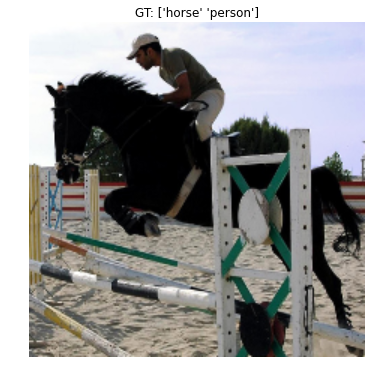

In [8]:
transformer = caffe.io.Transformer({'data': (1,3,224,224)})
transformer.set_mean('data', np.load('../python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)

image_index = 0 # First image in the batch.
plt.figure()
plt.imshow(transformer.deprocess('data',copy(solver.net.blobs['data'].data[image_index, ...])))
gtlist = solver.net.blobs['label'].data[image_index, ...].astype(np.int)
plt.title('GT: {}'.format(classes[np.where(gtlist)]))
plt.axis('off');

In [ ]:
for itt in range(100):
    solver.step(100)
    print 'itt:{:3d}'.format((itt + 1) * 100), 'Accuracy: ', solver.test_nets[0].blobs['accuracy'].data

TypeError: deprocess() takes exactly 2 arguments (3 given)

(3, 224, 224)